<a href="https://colab.research.google.com/github/NeuroCodeInnovations/Estimacion_Peso_Cuyes/blob/main/ResNet50/ResNet50_Estimacion_Cuyes_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimación del peso del cuy usando ResNet

# Instalaciones previas

Montar Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importar librerias

In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import numpy as np
import matplotlib.pyplot as plt

# Agregar un scheduler para reducir la tasa de aprendizaje cuando el 'loss' se estanca
from torch.optim.lr_scheduler import ReduceLROnPlateau

## Obtener la media y la std de una imagen

In [ ]:
ruta = '/content/drive/MyDrive/IMAG_CUYES/train_augmentation/BLUR_B_CUY_01_001_01.jpg'
img = Image.open(ruta)

# funcion de transformación
transform = transforms.Compose([
    transforms.ToTensor()
])
# transformar imagen PIL en imagen tensor
img_tr = transform(img)
# calcular mean y std
mean, std = img_tr.mean([1,2]), img_tr.std([1,2])

print("mean and std before normalize:")
print("Mean of the image:", mean)
print("Std of the image:", std)


mean and std before normalize:
Mean of the image: tensor([0.4424, 0.3786, 0.3175])
Std of the image: tensor([0.1140, 0.1074, 0.1085])


([], [])

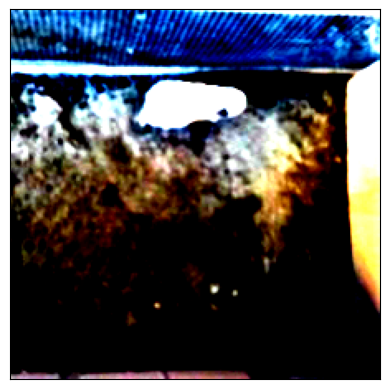

In [ ]:
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# get normalized image
img_normalized = transform_norm(img)

# convert this image to numpy array
img_normalized = np.array(img_normalized)

# transpose from shape of (3,,) to shape of (,,3)
img_normalized = img_normalized.transpose(1, 2, 0)

# display the normalized image
plt.imshow(img_normalized)
plt.xticks([])
plt.yticks([])

## Obtener mean y std globales

In [ ]:
def calculate_mean_std(images_folder):
    transform = transforms.ToTensor()

    mean = torch.zeros(3)
    std = torch.zeros(3)
    count = 0

    for img_name in os.listdir(images_folder):
        img_path = os.path.join(images_folder, img_name)

        if os.path.isfile(img_path):
            img = Image.open(img_path).convert("RGB")
            img_tensor = transform(img)
            mean += img_tensor.mean(dim=(1, 2))
            std += img_tensor.std(dim=(1, 2))
            count += 1

    mean /= count
    std /= count

    return mean, std

train_folder = '/content/drive/MyDrive/IMAG_CUYES/train_augmentation'
mean, std = calculate_mean_std(train_folder)
print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.5323, 0.4693, 0.4120])
Std: tensor([0.1710, 0.1634, 0.1586])


Resultados de la media y la desviacion globales:


In [ ]:
#Mean= tensor([0.5323, 0.4693, 0.4120])
mean = [0.5323, 0.4693, 0.4120]
#Std= tensor([0.1710, 0.1634, 0.1586])
std = [0.1710, 0.1634, 0.1586]

Mostrar imagen

([], [])

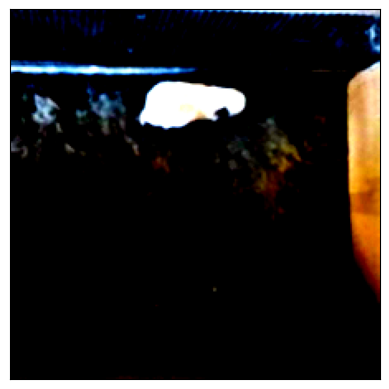

In [ ]:
ruta = '/content/drive/MyDrive/IMAG_CUYES/train_augmentation/BLUR_B_CUY_01_001_01.jpg'
img = Image.open(ruta)

transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# get normalized image
img_normalized = transform_norm(img)

# convert this image to numpy array
img_normalized = np.array(img_normalized)

# transpose from shape of (3,,) to shape of (,,3)
img_normalized = img_normalized.transpose(1, 2, 0)

# display the normalized image
plt.imshow(img_normalized)
plt.xticks([])
plt.yticks([])


# Cargar e inspeccionar los datos


Datos de entrenamiento

In [ ]:
image_train_path = '/content/drive/MyDrive/IMAG_CUYES/train_augmentation'
weights_train_path = '/content/drive/MyDrive/IMAG_CUYES/weights_train_augmentation.txt'

weights_train_df = pd.read_csv(weights_train_path, header=None, names=['filename', 'weight'])
weights_train_df['weight'] = weights_train_df['weight'].astype(float)

In [ ]:
print(weights_train_df.head())

              filename     weight
0  B_CUY_01_010_11.jpg  553.38224
1  B_CUY_01_097_09.jpg  521.63080
2  B_CUY_01_105_06.jpg  403.69688
3    CUY_01_059_14.jpg  648.63656
4  B_CUY_01_032_06.jpg  535.23856


Datos de validacion

In [ ]:
image_val_path = '/content/drive/MyDrive/IMAG_CUYES/val'
weights_val_path = '/content/drive/MyDrive/IMAG_CUYES/weights_val.txt'

weights_val_df = pd.read_csv(weights_val_path, header=None, names=['filename', 'weight'])
weights_val_df['weight'] = weights_val_df['weight'].astype(float)

In [ ]:
print(weights_val_df.head())

              filename     weight
0  B_CUY_01_071_09.jpg  403.69688
1    CUY_01_045_03.jpg  934.39952
2  B_CUY_01_071_01.jpg  403.69688
3    CUY_00_023_05.jpg  949.00000
4    CUY_00_090_11.jpg  900.00000


Datos de testeo

In [ ]:
image_test_path = '/content/drive/MyDrive/IMAG_CUYES/test'
weights_test_path = '/content/drive/MyDrive/IMAG_CUYES/weights_test.txt'

weights_test_df = pd.read_csv(weights_test_path, header=None, names=['filename', 'weight'])
weights_test_df['weight'] = weights_test_df['weight'].astype(float)

# Transformar los datos
Función para crear la clase DataSet de Pytorch para el entrenamiento

In [ ]:
class GuineaPigDataset(Dataset):
    def __init__(self, images_folder, weights_df, transform=None):
        self.images_folder = images_folder
        self.weights_df = weights_df
        self.transform = transform

    def __len__(self):
        return len(self.weights_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_folder, self.weights_df.iloc[idx, 0])

        # Verifica si el archivo existe
        if not os.path.exists(img_name):
            print(f"Archivo no encontrado: {img_name}")

        image = Image.open(img_name).convert("RGB")
        weight = self.weights_df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(weight, dtype=torch.float32)

In [ ]:
# Transformación
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # ResNet espera imágenes de 256x256
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Normalización para ResNet (ImageNet)
    transforms.Normalize(mean, std),
])
#https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/

# Carga de datos de la carpeta train
train_data = GuineaPigDataset(image_train_path, weights_train_df, transform=transform)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
print(f"Cantidad de datos en el dataset de entrenamiento: {len(train_data)}")

# Carga de datos de la carpeta test
val_data = GuineaPigDataset(image_val_path, weights_val_df, transform=transform)
val_loader = DataLoader(val_data, batch_size=16, shuffle=True)
print(f"Cantidad de datos en el dataset de validación: {len(val_data)}")

# Carga de datos de la carpeta test
test_data = GuineaPigDataset(image_test_path, weights_test_df, transform=transform)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)
print(f"Cantidad de datos en el dataset de testeo: {len(test_data)}")

Cantidad de datos en el dataset de entrenamiento: 10947
Cantidad de datos en el dataset de validación: 457
Cantidad de datos en el dataset de testeo: 457


# Modificar ResNet para regresión

Usaremos ResNet-50 y reemplazaremos la última capa para que tenga una salida única

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Cargar el modelo preentrenado ResNet-50
model = models.resnet50(pretrained=True)  # se descarga preentrenado

# Modificar la última capa para regresión
model.fc = nn.Linear(model.fc.in_features, 1)  # 1 salida para el peso

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 137MB/s]


# Configurar el entrenamiento

Definiremos el optimizador, la función de pérdida y el ciclo de entrenamiento. Para regresión, usamos el error cuadrático medio (MSE) como función de pérdida.

In [ ]:
import torch.optim as optim

# Configurar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

if torch.cuda.is_available():
    print(f"GPU disponible: {torch.cuda.get_device_name(0)}")
else:
    print("No hay GPU disponible, se utilizará la CPU.")

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()  #(Error Cuadrático Medio) mide la diferencia promedio al cuadrado entre las predicciones del modelo y los valores reales.

# Usar AdamW en lugar de Adam para mejorar la convergencia
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

# Crear el scheduler que reduce la tasa de aprendizaje cuando el 'loss' no mejora
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


GPU disponible: Tesla T4


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Entrenar el modelo



In [ ]:
num_epochs = 10  # Ajusta según el rendimiento y los recursos disponibles

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, weights in train_loader:
        images, weights = images.to(device), weights.to(device).unsqueeze(1)  # Esto convierte weights de [batch] a [batch, 1]

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, weights)

        # Backward y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()


    # Validación
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, weights in val_loader:
            images, weights = images.to(device), weights.to(device).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, weights)
            val_loss += loss.item()

    epoch_train_loss = train_loss / len(train_loader.dataset)
    epoch_val_loss = val_loss / len(val_loader.dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

    # Ajustar la tasa de aprendizaje con el scheduler
    scheduler.step(epoch_val_loss)  # Se usa el val_loss para el ajuste del scheduler

    # Guardar el modelo en cada época
    torch.save(model.state_dict(), f'/content/drive/MyDrive/EPOCHS/06/weights_epoch_{epoch+1}.pth')

Epoch [1/10], Train Loss: 35310.3405, Val Loss: 26219.4530
Epoch [2/10], Train Loss: 16468.7301, Val Loss: 6823.5732
Epoch [3/10], Train Loss: 4903.1933, Val Loss: 3632.1956
Epoch [4/10], Train Loss: 1550.4652, Val Loss: 2176.0349
Epoch [5/10], Train Loss: 940.7578, Val Loss: 1958.0481
Epoch [6/10], Train Loss: 821.8820, Val Loss: 1526.5840
Epoch [7/10], Train Loss: 719.5317, Val Loss: 1953.2435
Epoch [8/10], Train Loss: 497.6522, Val Loss: 1561.9052
Epoch [9/10], Train Loss: 389.2265, Val Loss: 1430.5331
Epoch [10/10], Train Loss: 234.6678, Val Loss: 1388.2582


# Evaluar el modelo

Cargar el modelo entrenado

In [ ]:
# Suponiendo que tu modelo se guarda como 'mode l.pth'
model = models.resnet50(pretrained=False)
num_classes = 1  # Cambia esto según el número de clases
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Carga los pesos del modelo

model.load_state_dict(torch.load('/content/drive/MyDrive/EPOCHS/06/weights_epoch_10.pth'))
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-4-5e7271277878>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Obtener la mean y std globales

In [ ]:
test_folder = '/content/drive/MyDrive/IMAG_CUYES/test'
mean, std = calculate_mean_std(test_folder)
print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.5517, 0.4991, 0.4579])
Std: tensor([0.1631, 0.1622, 0.1663])


Resultados de la media y std globales de la carpeta test

In [ ]:
#Mean= tensor([0.5517, 0.4991, 0.4579])
mean = [0.5517, 0.4991, 0.4579]
#Std= tensor([0.1631, 0.1622, 0.1663])
std = [0.1631, 0.1622, 0.1663]

Preparar las transformaciones de la imagen

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Ajusta el tamaño según el modelo
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

Función para evaluar y predecir

In [ ]:
def evaluate_model(model, image_folder):
    predictions = []

    for img_name in os.listdir(image_folder):
        img_path = os.path.join(image_folder, img_name)
        img = Image.open(img_path).convert('RGB')
        img = transform(img)
        img = img.unsqueeze(0)  # Añadir dimensión de batch

        with torch.no_grad():
            output = model(img)
            prediction = output.item()  # Obtener el valor escalar
            predictions.append((img_name, prediction))

    return predictions

# Ejecutar la evaluación

Llama a la función y pasa la carpeta de imágenes de prueba.

In [ ]:
image_folder = '/content/drive/MyDrive/IMAG_CUYES/test'
predictions = evaluate_model(model, image_folder)

# Convertir a un DataFrame para facilitar la visualización
predictions_df = pd.DataFrame(predictions, columns=['Imagen', 'Predicción (gramos)'])
print(predictions_df)

                Imagen  Predicción (gramos)
0    CUY_01_024_08.jpg           557.909668
1    CUY_01_024_01.jpg           576.706604
2    CUY_00_217_01.jpg           914.812988
3    CUY_01_024_04.jpg           634.672852
4    CUY_01_024_05.jpg           644.458740
..                 ...                  ...
450  CUY_01_035_01.jpg           490.589996
451  CUY_01_026_13.jpg           741.053284
452  CUY_01_026_11.jpg           740.685486
453  CUY_01_026_03.jpg           663.675781
454  CUY_01_035_05.jpg           630.899048

[455 rows x 2 columns]


# Evaluar la precisión

Comparar las predicciones con los pesos reales para evaluar el rendimiento del modelo.

In [ ]:
# Cargar los pesos reales
weights_df = pd.read_csv('/content/drive/MyDrive/IMAG_CUYES/weights_test.txt', sep=',', header=None, names=['Imagen', 'Peso'])
merged_df = pd.merge(predictions_df, weights_df, on='Imagen', how='inner')
merged_df['Error'] = merged_df['Predicción (gramos)'] - merged_df['Peso']

print(merged_df.head())  # Muestra las primeras filas del DataFrame
#print(merged_df.info())  # Información sobre el DataFrame (incluyendo conteo de nulos)


              Imagen  Predicción (gramos)       Peso       Error
0  CUY_01_024_08.jpg           557.909668   771.1064 -213.196732
1  CUY_01_024_01.jpg           576.706604   771.1064 -194.399796
2  CUY_00_217_01.jpg           914.812988  1014.0000  -99.187012
3  CUY_01_024_04.jpg           634.672852   771.1064 -136.433548
4  CUY_01_024_05.jpg           644.458740   771.1064 -126.647660


Guardar los resultados de la prueba

In [ ]:
# Guardar el DataFrame en un archivo .txt
ruta = '/content/drive/MyDrive/RESULTADOS/06/resultados_errores.txt'
merged_df.to_csv(ruta, sep='\t', index=False)

print("Archivo 'resultados_errores.txt' generado exitosamente.")

Archivo 'resultados_errores.txt' generado exitosamente.


Metricas

In [ ]:
# Calcular métricas como el error cuadrático medio (RMSE)
rmse = (merged_df['Error']**2).mean()**0.5
print(f'RMSE: {rmse:.4f}')


# Calculamos el MAE (Mean Absolute Error)
mae = (merged_df['Predicción (gramos)'] - merged_df['Peso']).abs().mean()
print(f'MAE: {mae:.4f}')

RMSE: 144.2684
RMSE: 110.4594


Mostar imagen

([], [])

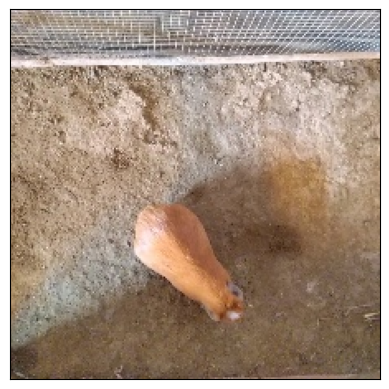

In [ ]:
ruta_carpeta = '/content/drive/MyDrive/IMAG_CUYES/test/'
nombre_img = 'B_CUY_01_043_05.jpg'
ruta_img = ruta_carpeta + nombre_img
img = Image.open(ruta_img)

# display the normalized image
plt.imshow(img)
plt.xticks([])
plt.yticks([])

Mostrar aquellas imagenes que contengan un error mayor a 200

In [ ]:
# Ruta del archivo .txt y la carpeta de imágenes
ruta_txt = '/content/drive/MyDrive/IMAG_CUYES/resultados_errores.txt'
ruta_carpeta_imagenes = '/content/drive/MyDrive/IMAG_CUYES/test/'

# Cargar el archivo .txt en un DataFrame
df = pd.read_csv(ruta_txt, sep=r'\t', engine='python')
print(df.columns)

# Filtrar las imágenes con error absoluto mayor a 200
df_filtrado = df[df['Error'].abs() > 200]

# Contar cuántas imágenes cumplen con la condición
cantidad_imagenes_error = len(df_filtrado)
print(f"Total de imágenes con error absoluto mayor a 200: {cantidad_imagenes_error}")

# Mostrar las imágenes filtradas
for _, row in df_filtrado.iterrows():
    ruta_imagen = os.path.join(ruta_carpeta_imagenes, row['Imagen'])
    img = Image.open(ruta_imagen)
    plt.imshow(img)
    plt.title(f"Error: {row['Error']:.2f}")
    plt.axis('off')
    plt.show()

Imagenes con bajo error

In [ ]:
# Ruta del archivo .txt y la carpeta de imágenes
ruta_txt = '/content/drive/MyDrive/IMAG_CUYES/resultados_errores.txt'
ruta_carpeta_imagenes = '/content/drive/MyDrive/IMAG_CUYES/test/'

# Cargar el archivo .txt en un DataFrame
df = pd.read_csv(ruta_txt, sep=r'\t', engine='python')
print(df.columns)

# Filtrar las imágenes con error absoluto mayor a 200
df_filtrado = df[df['Error'].abs() < 50]

# Contar cuántas imágenes cumplen con la condición
cantidad_imagenes_error = len(df_filtrado)
print(f"Total de imágenes con error absoluto menor a 50: {cantidad_imagenes_error}")

# Mostrar las imágenes filtradas
for _, row in df_filtrado.iterrows():
    ruta_imagen = os.path.join(ruta_carpeta_imagenes, row['Imagen'])
    img = Image.open(ruta_imagen)
    plt.imshow(img)
    plt.title(f"Error: {row['Error']:.2f}")
    plt.axis('off')
    plt.show()

Imagenes con un error mayor a 100

In [ ]:
# Filtrar las imágenes con error absoluto mayor a 200
df_filtrado = df[df['Error'].abs() > 100]

# Contar cuántas imágenes cumplen con la condición
cantidad_imagenes_error = len(df_filtrado)
print(f"Total de imágenes con error absoluto mayor a 200: {cantidad_imagenes_error}")

Total de imágenes con error absoluto mayor a 200: 202
